# Homework06

Exercises to practice pandas, data analysis and regression

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build intuition for different regression models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py

In [3]:
! pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LinearRegression, SGDRegressor
from data_utils import regression_error

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

#### WARNING

Like we mentioned in class, this dataset is being used for these exercises due to the level of detail in the dataset and the rigorous process that was used in collecting the data.

This is a very specific dataset and should not be used to draw general conclusions about people, bodies, or anything else that is not related to the distribution of physical features of U.S. Army personnel.

In [5]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [6]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [7]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

Min:
 age                     17.0
gender                   0.0
height                  56.0
weight                   0.0
span                  1323.0
stature               1409.0
ear.breadth             25.0
ear.length              46.0
ear.protrusion          13.0
foot.breadth            77.0
foot.length            198.0
hand.breadth            67.0
hand.length            145.0
hand.palm               88.0
head.height            206.0
head.circumference     502.0
dtype: float64

Max:
 age                     58.0
gender                   1.0
height                  94.0
weight                 321.0
span                  2121.0
stature               1993.0
ear.breadth             46.0
ear.length              81.0
ear.protrusion          34.0
foot.breadth           126.0
foot.length            323.0
hand.breadth           105.0
hand.length            239.0
hand.palm              140.0
head.height            295.0
head.circumference     635.0
dtype: float64

Mean:
 age                  

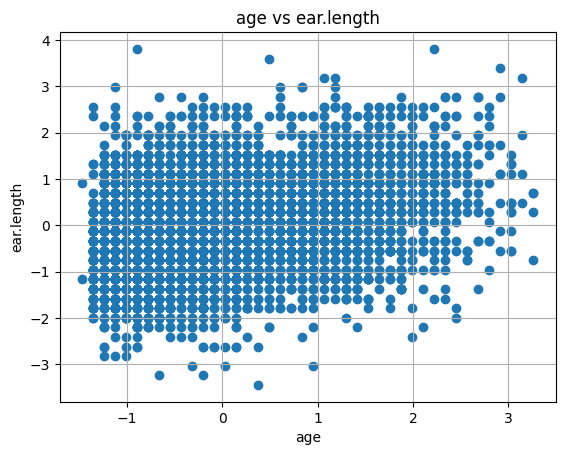

Most correlated to ear.length: weight (corr=0.49)


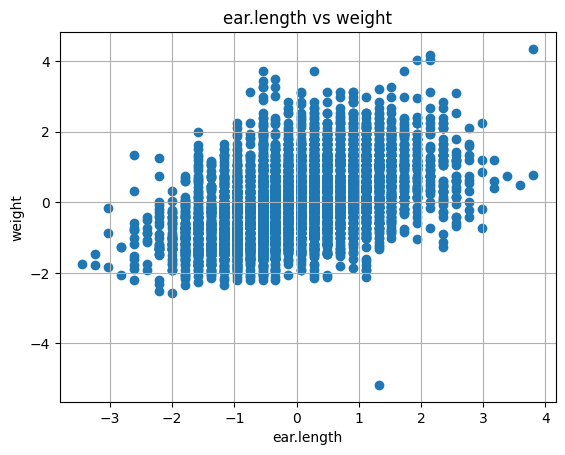

Most correlated to head.circumference: head.height (corr=0.55)


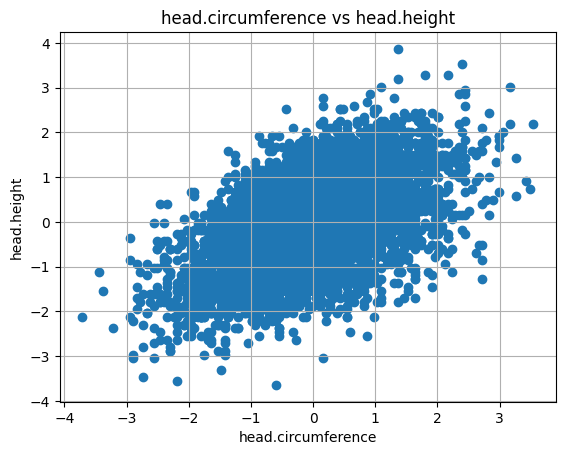

In [8]:
# Work on Data Exploration here

### Encode non-numerical features

## 1. Print min, max, avg

# Encode any non-numerical categorical columns (e.g. 'gender')
encoder = OrdinalEncoder()
if ansur_df["gender"].dtype == object:
    ansur_df["gender"] = encoder.fit_transform(ansur_df[["gender"]])

# Only keep numeric columns
numeric_df = ansur_df.select_dtypes(include='number')

# Min, Max, Avg
print("Min:\n", numeric_df.min())
print("\nMax:\n", numeric_df.max())
print("\nMean:\n", numeric_df.mean())


### Normalize all data

## 2. Print Covariances
# Normalize using StandardScaler
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)

# Covariance for selected features
features = ["age", "ear.length", "head.circumference"]
print("\nCovariance Table:\n", scaled_df[features].cov())

## 3. Plot features most correlated to age, ear length and head circumference
# Correlation matrix to find most correlated feature for each
correlations = scaled_df.corr()

# Plot each one with its most correlated feature
for feature in features:

    corr_series = correlations[feature].drop(feature).abs()
    most_corr = corr_series.idxmax()
    
    print(f"Most correlated to {feature}: {most_corr} (corr={correlations[feature][most_corr]:.2f})")
    
    plt.scatter(scaled_df[feature], scaled_df[most_corr])
    plt.title(f"{feature} vs {most_corr}")
    plt.xlabel(feature)
    plt.ylabel(most_corr)
    plt.grid(True)
    plt.show()


### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

<span style="color:hotpink;">Correlations are symmetric:
Yes — if A is highly correlated with B, then B is also highly correlated with A.
Scatterplot insights:
Age vs Ear Length → weak correlation (not much pattern).
Ear Length vs Weight → moderate positive trend.
Head Circumference vs Head Height → strong linear trend.
Conclusion:
Physical features (like ear length, head size) are more related to other body sizes than to age. This helps us choose better features for regression models.</span>

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 06](https://github.com/PSAM-5020-2025S-A/WK06) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

Train Error: 13.9106


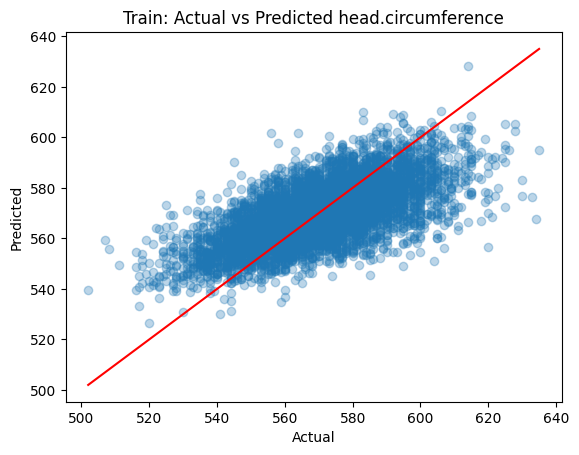

Test Error: 14.4732


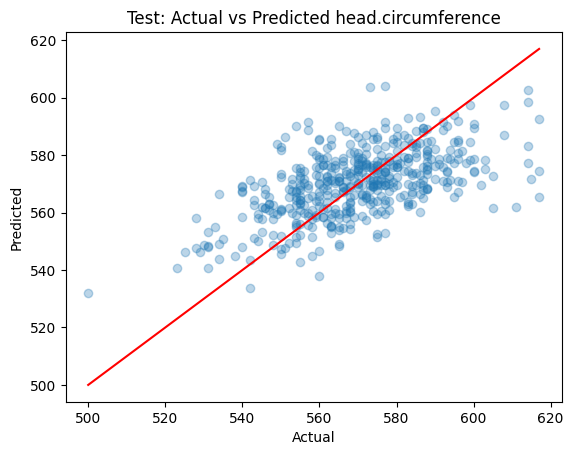

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from data_utils import object_from_json_url, LinearRegression, regression_error


# 1. Load Train Dataset

ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

ansur_df = pd.json_normalize(ansur_data)

# 2. Encode categorical column
ansur_encoder = OrdinalEncoder()
ansur_df[["gender"]] = ansur_encoder.fit_transform(ansur_df[["gender"]])  # F/M -> 0/1


# 3. Normalize all features
ansur_scaler = StandardScaler()
ansur_scaled = ansur_scaler.fit_transform(ansur_df)

ansur_df_scaled = pd.DataFrame(ansur_scaled, columns=ansur_df.columns)


# 4. Split into X and y
X_train = ansur_df_scaled.drop(columns=["head.circumference"])
y_train = ansur_df["head.circumference"]


# 5. Train regression model
model = LinearRegression()
model.fit(X_train, y_train)


# 6. Predict on training data
y_train_pred = model.predict(X_train)
train_error = regression_error(y_train, y_train_pred)
print(f"Train Error: {train_error:.4f}")

plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Train: Actual vs Predicted head.circumference")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="red")
plt.show()


# 7. Load Test Dataset
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur-test.json"
ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

# Same encoder & scaler used from training
ansur_test_df[["gender"]] = ansur_encoder.transform(ansur_test_df[["gender"]])
ansur_test_scaled = ansur_scaler.transform(ansur_test_df)
X_test = pd.DataFrame(ansur_test_scaled, columns=ansur_test_df.columns).drop(columns=["head.circumference"])
y_test = ansur_test_df["head.circumference"]


# 8. Predict on test data
y_test_pred = model.predict(X_test)
test_error = regression_error(y_test, y_test_pred)
print(f"Test Error: {test_error:.4f}")

plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Test: Actual vs Predicted head.circumference")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.show()


In [22]:
ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)

ansur_test_df = pd.json_normalize(ansur_test_data)

# Encode gender
ansur_test_encoded_df = ansur_test_df.copy()
g_vals = ansur_encoder.transform(ansur_test_df[["gender"]])
ansur_test_encoded_df[["gender"]] = g_vals

# Normalize
ansur_test_scaled = ansur_scaler.transform(ansur_test_encoded_df)

# Drop the target column for test input
X_test = pd.DataFrame(ansur_test_scaled, columns=ansur_test_encoded_df.columns).drop(columns=["head.circumference"])

# Define test target
y_test = ansur_test_df["head.circumference"]


Test Error: 14.4732


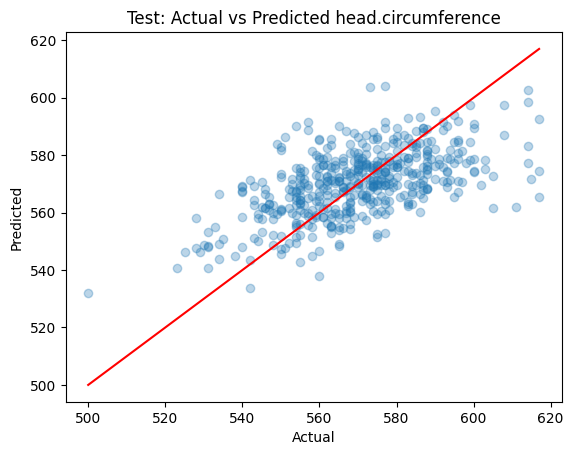

In [23]:
## Run model on test data
y_test_pred = model.predict(X_test)

## Measure error on test data
test_error = regression_error(y_test, y_test_pred)
print(f"Test Error: {test_error:.4f}")

## Plot predictions and interpret results
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Test: Actual vs Predicted head.circumference")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.show()


### Interpretation

<span style="color:hotpink;">
How well does your model perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:hotpink;">Interpretation

The model does okay, with a test error of 14.47.
Most predictions follow the trend, but it underpredicts large head sizes and overpredicts small ones.
To improve:
Try more advanced models like Ridge or Lasso.
Add new features or remove noisy ones.
The model struggles with extreme values, not the middle range.
</span>